In [1]:
import os
import cv2
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dir_path, transform=None):

        self.dir_path = dir_path
        self.transform = transform


        self.data= list(sorted(os.listdir(os.path.join(dir_path, "gt_vis"))))
        self.annotation= list(sorted(os.listdir(os.path.join(dir_path, "pred_vis"))))

    def __len__(self):
      return len(self.annotation)


    def __getitem__(self, idx):


        img_path = os.path.join(self.dir_path, "gt_vis", self.data[idx])
        ann_path = os.path.join(self.dir_path, "pred_vis", self.annotation[idx])
        image = cv2.imread(img_path)            
        label = cv2.imread(ann_path)

        if self.transform:
          image, label = self.transform(image, label)
        

        return image, label
        

In [3]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, label):
        for t in self.transforms:
            img, label = t(img), t(label)

        return img, label

    
#orginal dataset
orginal_transform = Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
  
])

torch.Size([128, 128, 3])
torch.Size([128, 128, 3])


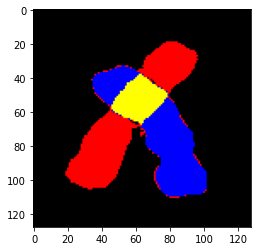

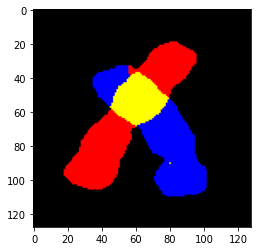

In [4]:
dataset= Dataset(dir_path= "./results/",transform= orginal_transform)
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
for x, y in loader:
    
    x= x[0].permute(1, 2, 0)
    y= y[0].permute(1, 2, 0)
    
    
    print(x.shape)
    print(y.shape)

    fig, ax = plt.subplots(1)
    ax.imshow(x)

    fig, ax = plt.subplots(1)
    ax.imshow(y)
    
    break

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / ((K.sum(y_true_f) + K.sum(y_pred_f) - intersection) + 1.0)


def precision(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    prec = (tp + smooth) / (tp + fp + smooth)
    return prec

def recall(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    tp = K.sum(y_pos * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall

def true_positive(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
    return tp

def true_negative(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
    return tn


def false_positive(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = (K.sum(y_neg * y_pred_pos) + smooth) / (K.sum(y_neg) + smooth)
    return tp

def false_negative(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_pos * y_pred_neg) + smooth) / (K.sum(y_pos) + smooth)
    return tn

def accuracy(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    tn = K.sum(y_neg * y_pred_neg)
    acc = (tp+tn + smooth) / (tp + tn + fn + fp + smooth)
    return acc

In [6]:
loader = DataLoader(dataset=dataset, batch_size=99, shuffle=True)
for x, y in loader:
    
    GT= x
    SR= y

    print("Accuracy : ", accuracy(SR,GT))
    print("Precision : ", precision(SR,GT))
    print("Recall : ", recall(SR,GT))
    print("Dice : ", dice_coef(SR,GT))
    print("IOU: ", jacard_coef(SR,GT))
    print("FNR: ", false_negative(SR,GT))
    print("FPR: ", false_positive(SR,GT))
    print("TNR: ", true_negative(SR,GT))
    print("TPR: ", true_positive(SR,GT))

Accuracy :  tf.Tensor(0.9683382, shape=(), dtype=float32)
Precision :  tf.Tensor(0.6710816, shape=(), dtype=float32)
Recall :  tf.Tensor(0.65509194, shape=(), dtype=float32)
Dice :  tf.Tensor(0.6629896, shape=(), dtype=float32)
IOU:  tf.Tensor(0.49587554, shape=(), dtype=float32)
FNR:  tf.Tensor(0.3449124, shape=(), dtype=float32)
FPR:  tf.Tensor(0.016026666, shape=(), dtype=float32)
TNR:  tf.Tensor(0.98397356, shape=(), dtype=float32)
TPR:  tf.Tensor(0.65509194, shape=(), dtype=float32)
